In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

In [2]:
source = 'sample_data/'
for file in os.listdir(source):
    
  

    if('.xml' in file):
        xml_path = source + file
    if('.jpg' in file):
        image_path = source + file
        
xml_path

'sample_data/201503.20150602.115901553.62766.orig.xml'

In [3]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from Mask_RCNN.mrcnn.utils import Dataset

import numpy as np
 
# class that defines and loads the dataset
# Dataset is a parent!!!
class GetDataset(Dataset):
    
    # load the dataset definitions
    def load_dataset(self, dataset_name):
        
        # 1 == the number of classes (not including background), 
        # dataset_name is to help keep track of what the instance of the
        # class is holding. In this case it's "sand_dollar"
        self.add_class('dataset', 1, dataset_name)
    
        # Will need to change this when we have the 
        # real dataset
        source = 'sample_data/'
        
        # Goes through all of the folder, records the basename of each file
        # then knowing that each the filenames are the same, just concats the suffix
        # to the basename, then appends each to their respective arrays
        
        # !!! Change to use glob instead of os !!!
        for file in os.listdir(source):
            
            # makes it so that we only loop through once and twice (i.e. creating duplicates)
            if(".orig.xml" in file):

                filename = file.split(".orig")[0]
                image_ids = filename

                xml_path =source + filename + ".orig.xml"

                image_path = source + filename + ".orig.jpg"
                
                self.add_image('dataset', image_id = image_ids, path = image_path, annotation = xml_path)        
            
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        
        # get the root of the document
        root = tree.getroot()
        
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        
        # get details of image
        info = self.image_info[image_id]
        
        # define box file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('sand_dollar'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [5]:
dataset_name = 'sand_dollar'

# train set
train_set = GetDataset()
train_set.load_dataset(dataset_name)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = GetDataset()
test_set.load_dataset(dataset_name)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 29
Test: 29


(1024, 1360, 3)
(1024, 1360, 1)


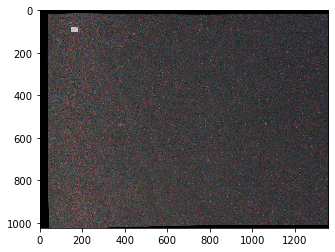

In [12]:
# Just a display of a image and a annotation
import matplotlib.pyplot as plt

index = np.random.randint(len(train_set.image_ids))

image = train_set.load_image(index)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(index)
print(mask.shape)
# plot image
plt.imshow(image)
# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

In [16]:
# Gives a view of what's going on in the object we created
def sanity_check(dataset):
    for image_id in dataset.image_ids:
        # load image info
        info = dataset.image_info[image_id]
        # display on the console
        print(info)
        
#sanity_check(train_set)

sample_data/201503.20150602.121647953.69138.orig.jpg
Number of annotations: 210


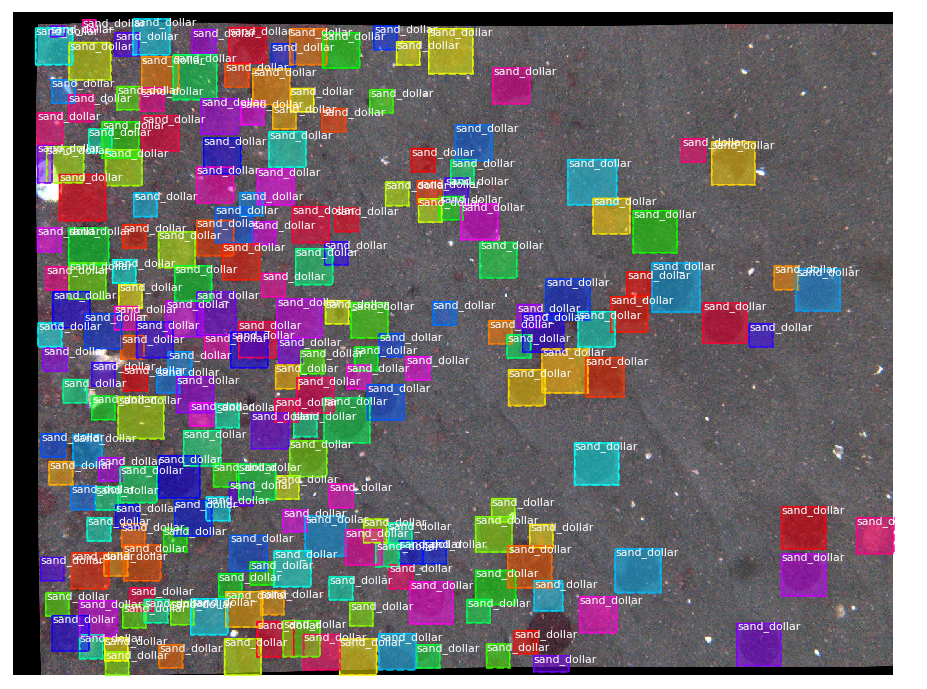

In [17]:
# Provides a better display of a image, and ALL of the annotations for said image
# takes a bit of time, blame the original repo, but at least it's pretty :)

from Mask_RCNN.mrcnn.visualize import display_instances
from Mask_RCNN.mrcnn.utils import extract_bboxes
# in visualize.py, change line 28 to "from Mask_RCNN.mrcnn import utils" :)

# define image id
index = 5

print(train_set.image_reference(index))

# load the image
image = train_set.load_image(index)

# load the masks and the class ids
mask, class_ids = train_set.load_mask(index)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)

print("Number of annotations:", mask.shape[2])
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
# define a configuration for the model
class Config(Config):
    # define the name of the configuration
    NAME = "sand_dollar_config"
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = 